In [24]:
#------------Joining x-ray data tables-----------

#Imported some stuff. 
from astropy.io import fits, ascii
from astropy.table import Table, join
import numpy as np

#Open the .dat files
galdict = {0:'COS', 1:'GDS', 2:'EGS', 3:'UDS'}
cpts = []
tbls = []

for k, v in galdict.items():
    cpts.append(Table(ascii.read("xray_counterparts." + v + ".080116.dat")))
    cpts[k]['field'] = [v]
    cpts[k].rename_column('col2', 'ID')
    cpts[k].rename_column('col13', 'HLx')
    tbls.append(None)
    tbls[k] = cpts[k]['field','ID','HLx']

#Calculate BHAR
t = join(join(join(tbls[0], tbls[1],join_type='outer'), tbls[2], join_type='outer'), tbls[3], join_type='outer')
t.sort('HLx')
t = t[405:len(t['HLx'])]

t['lbol'] = [0.0]
t['BHAR_xray'] = [0.0]

def bhar(i):     
    #lbol from lx; log ergs/s 
    t[i]['lbol'] = -9.25 + 1.25 * t[i]['HLx']

    #BHAR from lbol; log Msun/yr 
    t[i]['BHAR_xray'] = (9 * 10 ** t[i]['lbol'])/(29979245800 ** 2)
    if t[i]['BHAR_xray'] > 0: 
        t[i]['BHAR_xray'] = np.log10(t[i]['BHAR_xray']) + np.log10(1.58649268) - 26
    else: 
        t[i]['BHAR_xray'] = 0.0
        
for i in range(len(t['BHAR_xray'])):
    bhar(i)

candels = ascii.read('CANDELS_z.txt')
combo = join(t, candels['field','ID','M_med','zbest','BHAR'], keys = ['field','ID'])

combo.sort(['zbest'])
combo.write('CANDELS_xray_combo.txt', format='ascii.latex', overwrite=True)


for i in range(len(combo['zbest'])):
    if combo[i]['zbest'] >= 1.25:
        print i
        break
        
for i in range(len(combo['zbest'])):
    if combo[i]['zbest'] >= 1.75:
        print i
        break
combo

56
115


field,ID,HLx,lbol,BHAR_xray,M_med,zbest,BHAR
str3,int64,float64,float64,float64,float64,float64,float64
GDS,24554,42.1399,43.424875,-2.37408582379,10.77,0.761,-0.705828015524
UDS,24126,42.94556,44.43195,-1.36701082379,9.95279244304,0.769,-0.95738737542
UDS,9738,42.67783,44.0972875,-1.70167332379,10.6618126855,0.8048,-1.45075812682
EGS,15727,43.57463,45.2182875,-0.580673323789,10.9604,0.806,-1.04546666152
GDS,1864,41.94347,43.1793375,-2.61962332379,9.61,0.824,-1.56940812682
EGS,24456,43.43375,45.0421875,-0.756773323789,10.1984,0.833,-1.29397062682
COS,15095,43.96021,45.7002625,-0.0986983237891,10.279,0.837,-1.24735812682
GDS,24716,43.92344,45.6543,-0.144660823789,9.85,0.837,-0.285219437611
GDS,20585,41.99517,43.2439625,-2.55499832379,9.46,0.839,-0.697353015524


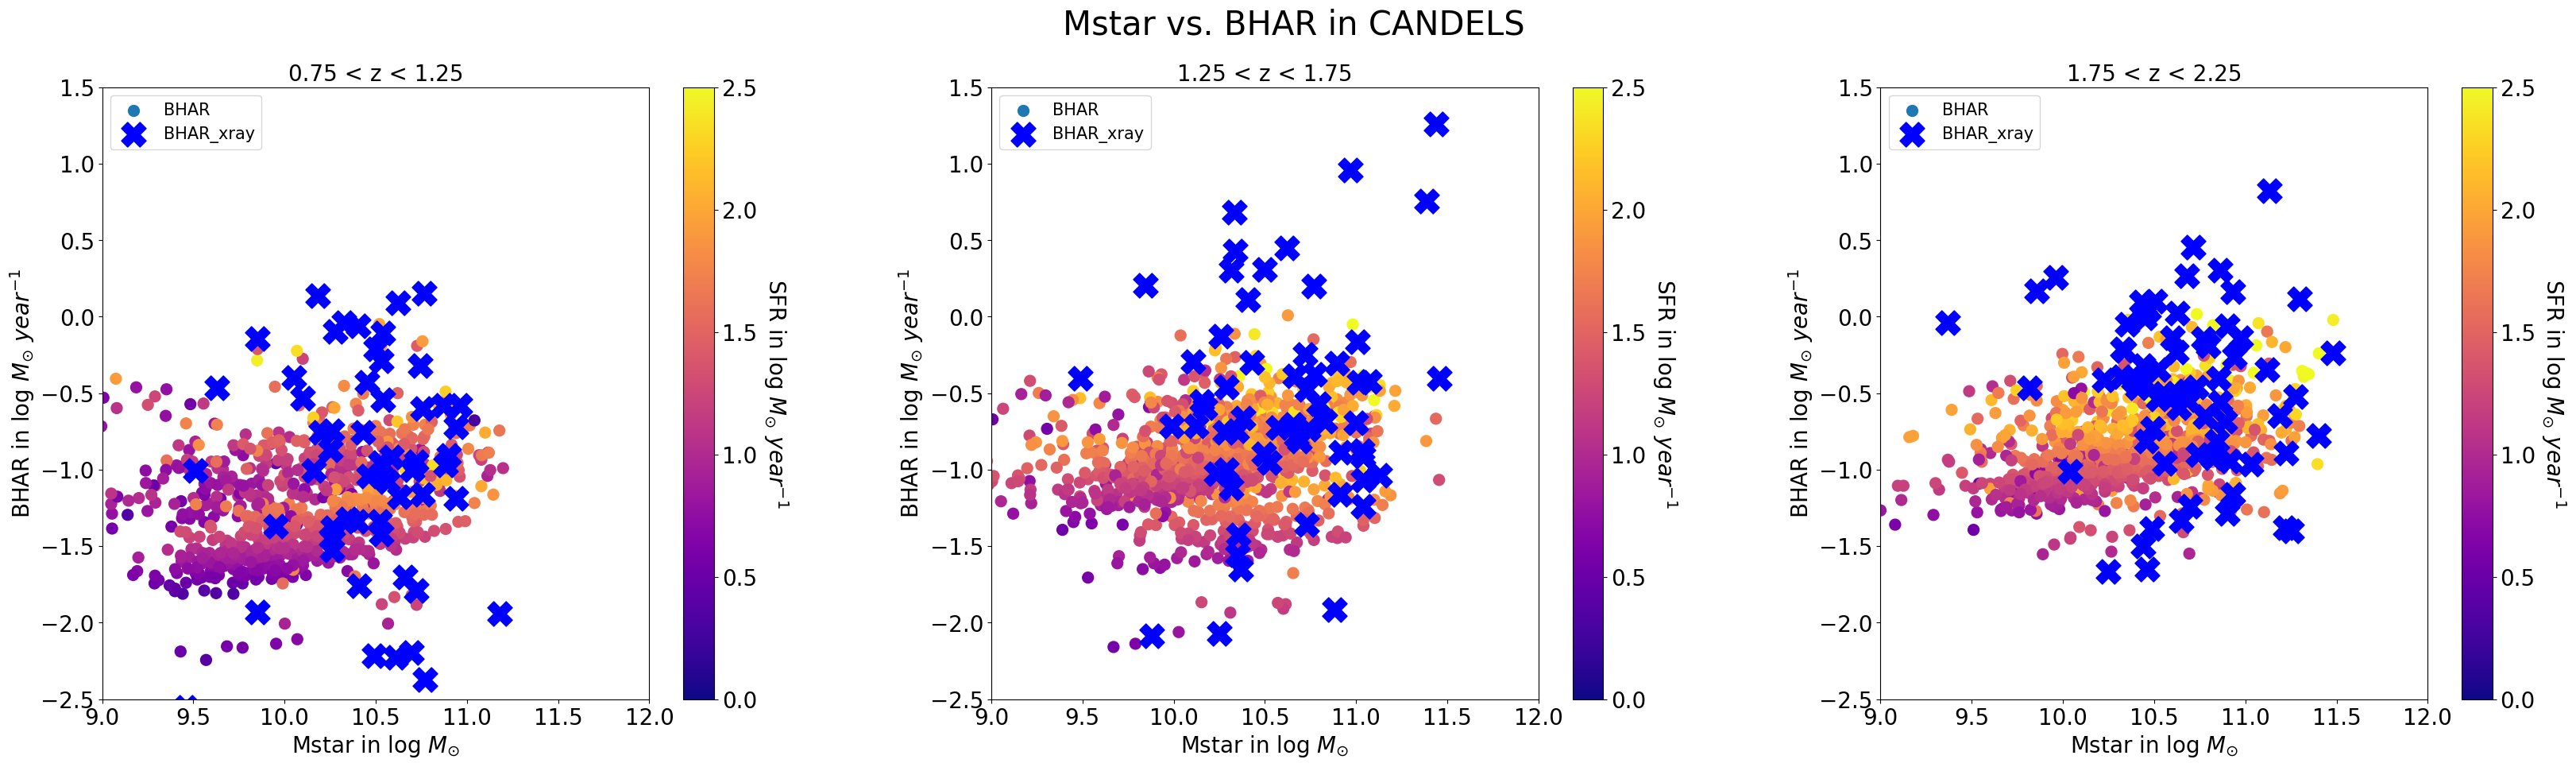

In [2]:
#------------------------SFR, BHAR scatterplots--------------------------------------

#import stuff
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np

%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc")
%matplotlib inline
from matplotlib import cm  
    
#Set up the figure
fig = plt.figure()
fig.set_size_inches(40,10)
fig.suptitle('Mstar vs. BHAR in CANDELS', fontsize=30)
    
#What table to use? 
t = ascii.read('CANDELS_z.txt')
xr = ascii.read('CANDELS_xray_combo.txt')
    
#lists
ax = []
colorm = []
scat = []
cb = []
titles = ['0.75','1.25','1.75','2.25']
zbin = [0,812,1898,2769]

for i in range(3): 
    colorm.append(None)
    scat.append(None)
    cb.append(None)

#Setting up the grid
for i in range(3):
    #Labels and titles
    ax.append(fig.add_subplot(1, 3, i+1))
    ax[i].set_xlabel('Mstar in log $M_{\odot}$', fontsize=20)
    ax[i].set_ylabel('BHAR in log $M_{\odot}$ ${year^{-1}}$', fontsize=20)
    ax[i].set_title(titles[i] + ' < z < ' + titles[i+1], fontsize=20)

    #Axis limits
    ax[i].set_xlim(9, 12)
    ax[i].set_ylim(-2.5, 1.5)
        
    #The data
    colorm[i] = t[zbin[i]:zbin[i+1]]['sfr']
    scat[i]=ax[i].scatter(t[zbin[i]:zbin[i+1]]['M_med'], t[zbin[i]:zbin[i+1]]['BHAR'], s=100,c=colorm[i],vmin=0,vmax=2.5,cmap=cm.plasma)

    cb[i] = fig.colorbar(scat[i], ax=ax[i])
    cb[i].set_label('SFR in log $M_{\odot}$ ${year^{-1}}$', rotation=270, labelpad=30, fontsize=20)
        

    #Tick mark label size
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    cb[i].ax.tick_params(labelsize=20) 

#Tune spacing between plots. 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
    
ax[0].scatter(xr[0:56]['M_med'], xr[0:56]['BHAR_xray'], s=500,facecolor=(0,0,1), marker='X')
ax[1].scatter(xr[56:115]['M_med'], xr[56:115]['BHAR_xray'], s=500,facecolor=(0,0,1), marker='X')
ax[2].scatter(xr[115:len(xr['zbest'])]['M_med'], xr[115:len(xr['zbest'])]['BHAR_xray'], s=500,facecolor=(0,0,1), marker='X')

for i in range(3):
    ax[i].legend(loc='upper left', fontsize=15)
    
fig.savefig('CANDELS_xrayBHARMstar.png', dpi=300, bbox_inches='tight')

y=0.215981x+(-0.617035)


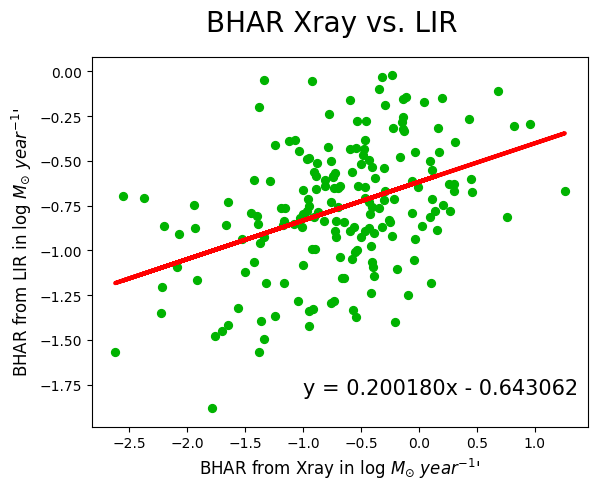

In [26]:
#------------Xray vs. LIR data-----------
#import stuff
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc")
%matplotlib inline


fig = plt.figure()
fig.suptitle('BHAR Xray vs. LIR', fontsize=20)

#-------Add data to the plots------
t = ascii.read('CANDELS_xray_combo.txt')
#t = t[83:len(t['zbest'])]

plt.xlabel("BHAR from Xray in log $M_{\odot}$ ${year^{-1}}$'", fontsize=12)
plt.ylabel("BHAR from LIR in log $M_{\odot}$ ${year^{-1}}$'", fontsize=12)
plt.scatter(t['BHAR_xray'],t['BHAR'],s=32,facecolor=(0,0.7,0))



#------I'm having trouble fitting the tredline----- 

#calc the trendline

z = np.polyfit(t['BHAR_xray'], t['BHAR'], 1)
p = np.poly1d(z)
plt.plot(t['BHAR_xray'],p(t['BHAR_xray']),"r-",lw=3)

# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

plt.text(-1, -1.8, 'y = 0.200180x - 0.643062', fontsize=15)

fig.savefig('BHAR_xray_lir.png', dpi=300, bbox_inches='tight')

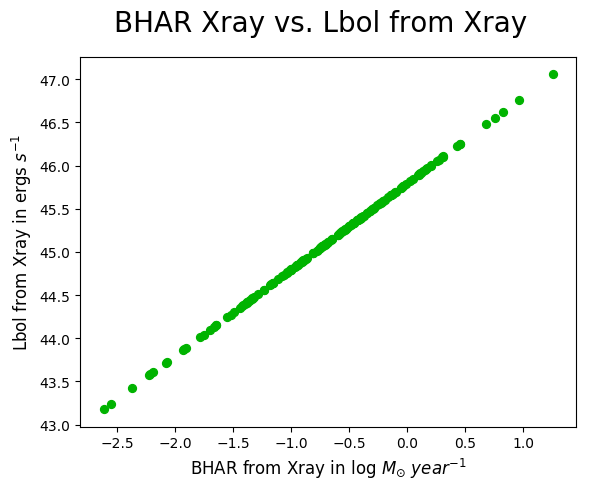

In [27]:
#------------Xray vs. LIR data-----------
#import stuff
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc")
%matplotlib inline


fig = plt.figure()
fig.suptitle('BHAR Xray vs. Lbol from Xray', fontsize=20)

#-------Add data to the plots------
t = ascii.read('CANDELS_xray_combo.txt')
#t = t[83:len(t['zbest'])]

plt.xlabel("BHAR from Xray in log $M_{\odot}$ ${year^{-1}}$", fontsize=12)
plt.ylabel("Lbol from Xray in ergs ${s^{-1}}$", fontsize=12)
plt.scatter(t['BHAR_xray'],t['lbol'],s=32,facecolor=(0,0.7,0))

fig.savefig('BHAR_xray_lbol.png', dpi=300, bbox_inches='tight')

In [9]:
#------------Joining x-ray data tables-----------

#Imported some stuff. 
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np

#Open the .dat files
galdict = {0:'COS', 1:'GDS', 2:'EGS', 3:'UDS'}
cpts = []
tbls = []

for k, v in galdict.items():
    cpts.append(Table(ascii.read("xray_counterparts." + v + ".080116.dat")))
    cpts[k]['field'] = [v]
    cpts[k].rename_column('col2', 'ID')
    cpts[k].rename_column('col13', 'HLx')
    tbls.append(None)
    tbls[k] = cpts[k]['field','ID','HLx']

#Calculate BHAR
t = join(join(join(tbls[0], tbls[1],join_type='outer'), tbls[2], join_type='outer'), tbls[3], join_type='outer')
t.sort('HLx')

for i in range(len(t['HLx'])):
    if t[i]['HLx'] > 0:
        print i
        break

405
